In [38]:
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import numpy as np
import os
from numba import jit
from IPython.display import display


%matplotlib inline
sns.set(style="white")

In [39]:
# Download current premier league table (though not sure if we'll ever use it :D)
team_dict = {}

url = 'http://www.espnfc.com/barclays-premier-league/23/table'
r  = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser') 
# Note: html5lib deals better with broken html than lxml

for td in soup.findAll('td', { 'class' : 'pos' }):
    rank = int(td.text)
    res = [i.text for i in td.next_siblings if isinstance(i, bs4.element.Tag) and i.text!='\xa0']
    team_name = res[0].strip()
    
    values = []
    for i in res[1:]:
        a = i.replace(u'\xa0', '0')
        values.append(int(a))
    
    team_dict[team_name] = [rank] + values
  

team_df = pd.DataFrame.from_dict(team_dict, orient='index')
cols = ['Pos','P_ov','W_ov','D_ov','L_ov','F_ov','A_ov',
            'W_hm','D_hm','L_hm','F_hm','A_hm', 'W_aw',
            'D_aw','L_aw','F_aw','A_aw','GD','PTS']
team_df.columns = cols
team_df = team_df.sort_values('Pos')
team_df['team'] = team_df.index
team_df = team_df[['team']+cols]
team_df.head(5)

,team,Pos,P_ov,W_ov,D_ov,L_ov,F_ov,A_ov,W_hm,D_hm,L_hm,F_hm,A_hm,W_aw,D_aw,L_aw,F_aw,A_aw,GD,PTS
Liverpool,Liverpool,1,6,6,0,0,17,5,3,0,0,10,3,3,0,0,7,2,12,18
Manchester City,Manchester City,2,6,4,1,1,24,6,2,1,0,14,2,2,0,1,10,4,18,13
Leicester City,Leicester City,3,6,3,2,1,8,5,2,1,0,5,2,1,1,1,3,3,3,11
Arsenal,Arsenal,4,6,3,2,1,11,10,2,1,0,7,5,1,1,1,4,5,1,11
West Ham United,West Ham United,5,6,3,2,1,8,7,2,0,1,4,5,1,2,0,4,2,1,11


In [40]:
# Download players from the FPL site's resource API
url = "https://fantasy.premierleague.com/api/bootstrap-static/"
r  = requests.get(url)
data = json.loads(r.text)

all_players = data['elements']
all_teams = data['teams']

team_codes = {}
for team in all_teams:
    team_codes[int(team['code'])] = team['short_name']
  

# Assemble data frame of players
df_players = pd.DataFrame(columns=['PlayerId', 'Player', 'Position', 'Cost', 'Status', 'Team', 'Selected'])

for i in all_players:
    # some players get transferred out of PL and have invalid teams
    try:
        team_id = team_codes[i['team_code']]
    except KeyError:
        team_id = ''
        print("KeyError - player has invalid team: id %d, team code%d" % (i['id'], i['team_code']))
   

    df_players = df_players.append({'PlayerId' : i['id'],
                                    'Player': i['web_name'],
                                    'Position': i['element_type'],
                                    'Cost': i['now_cost'],
                                    'Status': i['status'],
                                    'Team': team_id,
                                    'Selected': i['selected_by_percent'],
                                   }, ignore_index=True)


df_players.set_index('PlayerId', inplace=True)
df_players['Cost'] = df_players['Cost'].astype('int64') 
df_players.head()      

,Player,Position,Cost,Status,Team,Selected
PlayerId,,,,,,
1,Mustafi,2,53,a,ARS,0.4
2,Bellerín,2,54,a,ARS,0.1
3,Kolasinac,2,54,a,ARS,0.8
4,Maitland-Niles,2,51,a,ARS,6.6
5,Sokratis,2,50,a,ARS,1.9


In [4]:
# Download player data per player

def download_player(i):
    url = "https://fantasy.premierleague.com/api/element-summary/" + str(i) + "/"
    r  = requests.get(url)

    return json.loads(r.text)


def extract_history(player, history):
    history_past = history
    
    hdict = {}
    pdict = {}
  
    # For history we only care about the points and minutes (although other performance data is available)
    for season in history_past:
        hdict[season['season_name'] + ' pts'] =  int(season['total_points'])
        hdict[season['season_name'] + ' mins'] =  int(season['minutes'])
    
    pdict[player] = hdict
    return pd.DataFrame().from_dict(pdict, orient='index')


def extract_current(player, season):
    history = season
    
    current_dict = {}
    pts_dict = {}
    
    # Dataset with points for current season
    
    for game in history:
        r = str(game['round'])
        pts_dict[r + ' pts'] = int(game['total_points'])
        pts_dict[r + ' mins'] = int(game['minutes'])
        pts_dict[r + ' home'] = game['was_home']
        pts_dict[r + ' val'] = int(game['value'])
        pts_dict[r + ' bonus'] = int(game['bonus'])
       
    
    current_dict[player] = pts_dict
    return pd.DataFrame().from_dict(current_dict, orient='index')
    
def extract_fixtures(player, season):
    fixtures = season
    
    fixtures_dict = {}
    fds_dict = {}
    
    # Get future fixture difficulties
    i = 0
    for fix in fixtures:
        r = str(i)
        fds_dict[r + ' fds'] = int(fix['difficulty'])
        i = i + 1
       
    
    fixtures_dict[player] = fds_dict
    return pd.DataFrame().from_dict(fixtures_dict, orient='index')
    

# Download the data per player and extract the fields we are interested in

df_history = pd.DataFrame()
df_current = pd.DataFrame()
df_fixtures = pd.DataFrame()

from ipywidgets import IntProgress
from IPython.display import display


f = IntProgress(min=0, max=len(df_players.index.values)) # instantiate the bar
display(f) # display the bar

for i in df_players.index.values: 
    f.value += 1 
    data = download_player(i)       
    df_history = df_history.append(extract_history(i, data['history_past']), sort=True)
    df_current = df_current.append(extract_current(i, data['history']), sort=True)
    df_fixtures = df_fixtures.append(extract_fixtures(i, data['fixtures']), sort=True)
    
df_current.head()       

IntProgress(value=0, max=541)

,1 bonus,1 home,1 mins,1 pts,1 val,2 bonus,2 home,2 mins,2 pts,2 val,...,5 bonus,5 home,5 mins,5 pts,5 val,6 bonus,6 home,6 mins,6 pts,6 val
1,0.0,False,0.0,0.0,55.0,0.0,True,0.0,0.0,55.0,...,0.0,False,0.0,0.0,53.0,0,True,0,0,53
2,0.0,False,0.0,0.0,55.0,0.0,True,0.0,0.0,55.0,...,0.0,False,0.0,0.0,54.0,0,True,0,0,54
3,0.0,False,0.0,0.0,55.0,0.0,True,19.0,1.0,55.0,...,0.0,False,90.0,3.0,54.0,0,True,90,1,54
4,3.0,False,90.0,12.0,50.0,0.0,True,90.0,2.0,50.0,...,0.0,False,90.0,4.0,51.0,0,True,40,-3,51
5,2.0,False,90.0,8.0,50.0,0.0,True,90.0,2.0,50.0,...,0.0,False,90.0,1.0,50.0,0,True,90,1,50


In [5]:
df_fixtures.head()

,0 fds,1 fds,10 fds,11 fds,12 fds,13 fds,14 fds,15 fds,16 fds,17 fds,...,29 fds,3 fds,30 fds,31 fds,4 fds,5 fds,6 fds,7 fds,8 fds,9 fds
1,4,2,4,4,3,4,4,2,2,4,...,4,2,2,2,2,3,2,3,2,3
2,4,2,4,4,3,4,4,2,2,4,...,4,2,2,2,2,3,2,3,2,3
3,4,2,4,4,3,4,4,2,2,4,...,4,2,2,2,2,3,2,3,2,3
4,4,2,4,4,3,4,4,2,2,4,...,4,2,2,2,2,3,2,3,2,3
5,4,2,4,4,3,4,4,2,2,4,...,4,2,2,2,2,3,2,3,2,3


In [6]:
# Assemble players with history
df = df_players.merge(right=df_history, how='left', left_index=True, right_index=True)
df = df.merge(right=df_current, how='left', left_index=True, right_index=True)
df = df.merge(right=df_fixtures, how='left', left_index=True, right_index=True)
df.head()

,Player,Position,Cost,Status,Team,Selected,2006/07 mins,2006/07 pts,2007/08 mins,2007/08 pts,...,29 fds,3 fds,30 fds,31 fds,4 fds,5 fds,6 fds,7 fds,8 fds,9 fds
PlayerId,,,,,,,,,,,,,,,,,,,,,
1,Mustafi,2,53,a,ARS,0.4,NaN,NaN,NaN,NaN,...,4,2,2,2,2,3,2,3,2,3
2,Bellerín,2,54,a,ARS,0.1,NaN,NaN,NaN,NaN,...,4,2,2,2,2,3,2,3,2,3
3,Kolasinac,2,54,a,ARS,0.8,NaN,NaN,NaN,NaN,...,4,2,2,2,2,3,2,3,2,3
4,Maitland-Niles,2,51,a,ARS,6.6,NaN,NaN,NaN,NaN,...,4,2,2,2,2,3,2,3,2,3
5,Sokratis,2,50,a,ARS,1.9,NaN,NaN,NaN,NaN,...,4,2,2,2,2,3,2,3,2,3


In [7]:
# Take a look at squad costs and points
df_teams = df.groupby(['Team']).sum()
df_teams['Team Cost per Point 2018/19'] = df_teams['Cost']/df_teams['2018/19 pts']
df_teams.sort_values('Team Cost per Point 2018/19')

,Cost,2006/07 mins,2006/07 pts,2007/08 mins,2007/08 pts,2011/12 mins,2011/12 pts,2012/13 mins,2012/13 pts,2013/14 mins,...,3 fds,30 fds,31 fds,4 fds,5 fds,6 fds,7 fds,8 fds,9 fds,Team Cost per Point 2018/19
Team,,,,,,,,,,,,,,,,,,,,,
LIV,1542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16624.0,...,100,100,50,50,100,50,50,50,75,0.702186
MCI,1633,0.0,0.0,0.0,0.0,1706.0,52.0,2628.0,64.0,12320.0,...,48,48,48,48,120,96,48,48,96,0.762016
WOL,1169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4770.0,...,46,46,92,92,46,69,46,69,46,0.769079
CRY,1163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19081.0,...,92,69,92,69,92,92,46,46,46,0.772757
EVE,1437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15652.0,...,52,52,52,104,52,52,78,130,104,0.821143
LEI,1371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2439.0,...,52,104,104,52,104,52,52,52,52,0.900788
TOT,1746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18265.0,...,150,90,60,120,60,90,60,120,60,0.937701
WAT,1377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9836.0,...,56,112,112,112,84,56,56,84,56,0.951624
CHE,1539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10799.0,...,54,135,54,54,54,135,81,54,108,0.974051


In [8]:
df_teams.columns
df.to_excel(r'Players_2019_2020.xlsx')
df_teams.to_excel(r'Teams_2018_19.xlsx')

# Pre season analysis

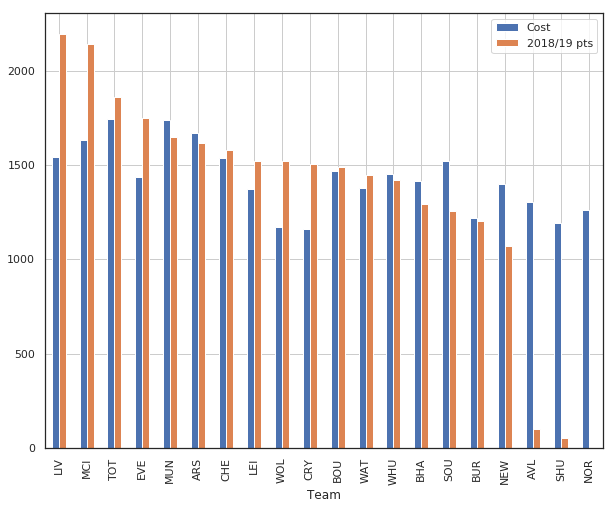

In [9]:
df_teams.sort_values('2018/19 pts', ascending=False).plot.bar(y=['Cost', '2018/19 pts'], figsize=(10,8), grid=True)

In [10]:
df_teams.sort_values('Team Cost per Point 2018/19', ascending=False)['Team Cost per Point 2018/19']

Team
NOR          inf
SHU    23.900000
AVL    13.171717
NEW     1.304753
SOU     1.211615
BHA     1.094208
MUN     1.052090
ARS     1.033395
WHU     1.022488
BUR     1.015820
BOU     0.985245
CHE     0.974051
WAT     0.951624
TOT     0.937701
LEI     0.900788
EVE     0.821143
CRY     0.772757
WOL     0.769079
MCI     0.762016
LIV     0.702186
Name: Team Cost per Point 2018/19, dtype: float64

This means we should favour players from the bottom of this list to maximise the points per money. 3 LIV yplayers, then WOL, CRY, MCI and EVE

In [11]:
# 38 fixtures per season. Which team had most players playing > 60 minutes per game
df_mins = df[df['2018/19 mins'] > (60 * 38)]
df_mins.groupby('Team').count()['Player']

Team
ARS     8
BHA     8
BOU     6
BUR     7
CHE     7
CRY     8
EVE     8
LEI     7
LIV     8
MCI     8
MUN     9
NEW     4
SOU     2
TOT     6
WAT     8
WHU     5
WOL    10
Name: Player, dtype: int64

This means teams like SOU have a high rotation risk. Should focus on WOL, LIV, MCI, LEI, WAT, CRY, EVE, BUR

# Use Integer Linear Programming to pick an optimal team based on last year's performance

In [12]:
# ILP team, inspiration from 
# https://github.com/kangeugine/fantasy-football/blob/master/%5BPart%202%5D%20Knapsack%20Problem.ipynb
from pulp import *

In [13]:
# only consider players who have data from last season
# what to do about all the new players in SHU and NOR?

def build_lp_vars(dfo):  
    lp_vars = {}
    
    lp_vars['player'] = [str(i) for i in dfo.index.tolist()]
    lp_vars['point'] = {str(i): int(dfo.loc[i]['2018/19 pts']) for i in dfo.index.tolist() }
    lp_vars['cost'] = {str(i): int(dfo.loc[i]['Cost']) for i in dfo.index.tolist()} 
    lp_vars['gk'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '1' else 0 for i in dfo.index.tolist()} 
    lp_vars['defe'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '2' else 0 for i in dfo.index.tolist()}
    lp_vars['mid'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '3' else 0 for i in dfo.index.tolist()}
    lp_vars['stri'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '4' else 0 for i in dfo.index.tolist()}

    # constrain on max 3 per team ... there may be a prettier way to do this .. 
    lp_vars['ars'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'ARS' else 0 for i in dfo.index.tolist()}
    lp_vars['bha'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BHA' else 0 for i in dfo.index.tolist()}
    lp_vars['bou'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BOU' else 0 for i in dfo.index.tolist()}
    lp_vars['bur'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BUR' else 0 for i in dfo.index.tolist()}
    lp_vars['che'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'CHE' else 0 for i in dfo.index.tolist()}
    lp_vars['cry'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'CRY' else 0 for i in dfo.index.tolist()}
    lp_vars['eve'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'EVE' else 0 for i in dfo.index.tolist()}
    lp_vars['lei'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'LEI' else 0 for i in dfo.index.tolist()}
    lp_vars['liv'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'LIV' else 0 for i in dfo.index.tolist()}
    lp_vars['mci'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'MCI' else 0 for i in dfo.index.tolist()}
    lp_vars['mun'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'MUN' else 0 for i in dfo.index.tolist()}
    lp_vars['new'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'NEW' else 0 for i in dfo.index.tolist()}
    lp_vars['sou'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'SOU' else 0 for i in dfo.index.tolist()}
    lp_vars['tot'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'TOT' else 0 for i in dfo.index.tolist()}
    lp_vars['wat'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WAT' else 0 for i in dfo.index.tolist()}
    lp_vars['whu'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WHU' else 0 for i in dfo.index.tolist()}
    lp_vars['wol'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WOL' else 0 for i in dfo.index.tolist()}
    lp_vars['nor'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'NOR' else 0 for i in dfo.index.tolist()}
    lp_vars['shu'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'SHU' else 0 for i in dfo.index.tolist()}
    lp_vars['avl'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'AVL' else 0 for i in dfo.index.tolist()}
    lp_vars['xi'] = {str(i): 1 for i in dfo.index.tolist()}
    
    return lp_vars
    
df_optimise = df[pd.notnull(df['2018/19 pts'])]
LP_VAR = build_lp_vars(df_optimise)

In [34]:
TEAMS = ['ars', 'bha', 'bou', 'bur', 'che', 'cry', 'eve', 'lei', 'liv', 'mci', 'mun',
         'new', 'sou', 'tot', 'wat', 'whu', 'wol', 'nor', 'shu', 'avl']

def build_lp_team(n_gk = 1, n_defe = 4, n_mid = 4, n_fwd = 2, tot_cost = 830, tot_players = 11, 
                tgt = LP_VAR['point'], lp_vars = LP_VAR):

    # objective function, maximise total points
    prob = LpProblem("Fantasy Football",LpMaximize)
    player = lp_vars['player']
    
    player_vars = LpVariable.dicts("Players",player,0,1,LpBinary)
    prob += lpSum([tgt[i]*player_vars[i] for i in player]), "Total Points"

    # Team configuration (adjust for 4-4-2, 4-3-3, etc.)
    prob += lpSum([player_vars[i] for i in player]) == tot_players, tot_players
    prob += lpSum([lp_vars['cost'][i] * player_vars[i] for i in player]) == tot_cost, "Total Cost Max Playing"
    prob += lpSum([lp_vars['gk'][i] * player_vars[i] for i in player]) == n_gk, "1 GK"
    prob += lpSum([lp_vars['defe'][i] * player_vars[i] for i in player]) == n_defe, "4 DEF"
    prob += lpSum([lp_vars['mid'][i] * player_vars[i] for i in player]) == n_mid, "4 MID"
    prob += lpSum([lp_vars['stri'][i] * player_vars[i] for i in player]) == n_fwd, "2 STR"

    
    for t in TEAMS:
        prob += lpSum([lp_vars[t][i] * player_vars[i] for i in player]) <= 3, t

    
    return prob

In [15]:
# solve
prob = build_lp_team()
status = prob.solve()
print("Status:", LpStatus[prob.status])

Status: Optimal


In [16]:
# Extract which players were picked by the solver and mark in our dataframe
def extract_xi(dfo, prob = prob):  

    # can't write to slice
    dfo = dfo.copy()
    
    selection = {}
    for v in prob.variables():
        index = int(v.name.split("_")[1])
        selection[index] = v.varValue

    dfo['integer_programming'] = 0.0
    for i in selection:
        dfo.loc[i, 'integer_programming'] = selection[i]
    
    return dfo[dfo['integer_programming'] == 1.0]

In [19]:
# stats from the selected 11
def print_summary_xi(df_optimise, prob, points = '2018/19 pts', cost = 'Cost'):
    xi = extract_xi(df_optimise, prob)
    t_points = xi[points].sum()
    t_cost = xi[cost].sum()/10
    t_players = xi.shape[0]
    print("Total points:{}, cost:£{}, and with players:{}\n".format(t_points, t_cost, t_players))
    
    return xi

In [45]:
# permute team formations

# 442
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 4, n_fwd = 2)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("442 formation")
xi442 = print_summary_xi(df_optimise, prob)
display(xi442[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))


# 433
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 3, n_fwd = 3)
status = prob.solve()

print("\n")
print("Status:", LpStatus[prob.status])
print("432 formation")
xi433 = print_summary_xi(df_optimise, prob)
display(xi433[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))


# 451
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 5, n_fwd = 1)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("451 formation")
xi451 = print_summary_xi(df_optimise, prob)
display(xi451[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))

# 352
prob = build_lp_team(n_gk = 1, n_defe = 3, n_mid = 5, n_fwd = 2)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("352 formation")
xi352 = print_summary_xi(df_optimise, prob)
display(xi352[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))



Status: Optimal
442 formation
Total points:2079.0, cost:£83.0, and with players:11



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Fabianski,1,WHU,143.0,50,5.8
1,David Luiz,2,ARS,164.0,58,5.6
2,Robertson,2,LIV,213.0,69,19.6
3,van Dijk,2,LIV,208.0,65,48.2
4,Laporte,2,MCI,177.0,63,2.8
5,Fraser,3,BOU,181.0,73,6.1
6,Milivojevic,3,CRY,166.0,67,3.5
7,Sigurdsson,3,EVE,182.0,77,4.7
8,Salah,3,LIV,259.0,125,42.1
9,Aubameyang,4,ARS,205.0,110,23.8




Status: Optimal
432 formation
Total points:2065.0, cost:£83.0, and with players:11



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Pickford,1,EVE,161.0,56,10.6
1,Alonso,2,CHE,161.0,62,2.4
2,Robertson,2,LIV,213.0,69,19.6
3,van Dijk,2,LIV,208.0,65,48.2
4,Laporte,2,MCI,177.0,63,2.8
5,Fraser,3,BOU,181.0,73,6.1
6,Sigurdsson,3,EVE,182.0,77,4.7
7,Salah,3,LIV,259.0,125,42.1
8,Callum Wilson,4,BOU,168.0,78,10.7
9,Vardy,4,LEI,174.0,89,8.4




Status: Optimal
451 formation
Total points:2076.0, cost:£83.0, and with players:11



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Pickford,1,EVE,161.0,56,10.6
1,David Luiz,2,ARS,164.0,58,5.6
2,Robertson,2,LIV,213.0,69,19.6
3,van Dijk,2,LIV,208.0,65,48.2
4,Laporte,2,MCI,177.0,63,2.8
5,Fraser,3,BOU,181.0,73,6.1
6,Kanté,3,CHE,116.0,50,4.8
7,Sigurdsson,3,EVE,182.0,77,4.7
8,Salah,3,LIV,259.0,125,42.1
9,Sterling,3,MCI,234.0,121,40.4




Status: Optimal
352 formation
Total points:2075.0, cost:£83.0, and with players:11



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Pickford,1,EVE,161.0,56,10.6
1,Robertson,2,LIV,213.0,69,19.6
2,van Dijk,2,LIV,208.0,65,48.2
3,Laporte,2,MCI,177.0,63,2.8
4,Fraser,3,BOU,181.0,73,6.1
5,Milivojevic,3,CRY,166.0,67,3.5
6,Sigurdsson,3,EVE,182.0,77,4.7
7,Salah,3,LIV,259.0,125,42.1
8,Pogba,3,MUN,179.0,84,4.4
9,Callum Wilson,4,BOU,168.0,78,10.7


# ILP, pick a bench for 17M



In [44]:
# Typical bench
prob = build_lp_team(n_gk = 1, n_defe = 1, n_mid = 1, n_fwd = 1, tot_players = 4, tot_cost = 170)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("1111 bench")
iv1111 = print_summary_xi(df_optimise, prob)
display(iv1111[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))

# Typical bench
prob = build_lp_team(n_gk = 1, n_defe = 2, n_mid = 0, n_fwd = 1, tot_players = 4, tot_cost = 170)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("1201 bench")
iv1201 = print_summary_xi(df_optimise, prob)
display(iv1201[['Player','Position', 'Team','2018/19 pts','Cost', 'Selected']]
     .sort_values(['Position'])
     .reset_index(drop=True))



Status: Optimal
1111 bench
Total points:120.0, cost:£17.0, and with players:4



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Button,1,BHA,15.0,40,25.4
1,Kelly,2,CRY,26.0,41,25.0
2,Hayden,3,NEW,69.0,45,6.7
3,Nketiah,4,ARS,10.0,44,0.9




Status: Optimal
1201 bench
Total points:183.0, cost:£17.0, and with players:4



,Player,Position,Team,2018/19 pts,Cost,Selected
0,Button,1,BHA,15.0,40,25.4
1,Taylor,2,BUR,82.0,43,0.7
2,Morgan,2,LEI,76.0,43,0.9
3,Nketiah,4,ARS,10.0,44,0.9


# 2019 Current Season

In [24]:
gw = 7
last = gw - 1

# reload players from local storage
df = pd.read_excel(r'Players_2019_2020.xlsx', sheet_name='Sheet1')
df.set_index('PlayerId', inplace=True)

base_cols = ['Position', 'Cost', 'Status', 'Team', 'Selected', '2018/19 pts']
pts_cols = [str(i) + ' pts' for i in range(1,gw)]
mins_cols = [str(i) + ' mins' for i in range(1,gw)]

# next 5 fixture difficulties
fds5_cols = [str(i) + ' fds' for i in range(0,5)]

val_col = str(last) + 'val'


In [25]:
df.columns

Index(['Player', 'Position', 'Cost', 'Status', 'Team', 'Selected',
       '2006/07 mins', '2006/07 pts', '2007/08 mins', '2007/08 pts',
       '2011/12 mins', '2011/12 pts', '2012/13 mins', '2012/13 pts',
       '2013/14 mins', '2013/14 pts', '2014/15 mins', '2014/15 pts',
       '2015/16 mins', '2015/16 pts', '2016/17 mins', '2016/17 pts',
       '2017/18 mins', '2017/18 pts', '2018/19 mins', '2018/19 pts', '1 bonus',
       '1 home', '1 mins', '1 pts', '1 val', '2 bonus', '2 home', '2 mins',
       '2 pts', '2 val', '3 bonus', '3 home', '3 mins', '3 pts', '3 val',
       '4 bonus', '4 home', '4 mins', '4 pts', '4 val', '5 bonus', '5 home',
       '5 mins', '5 pts', '5 val', '6 bonus', '6 home', '6 mins', '6 pts',
       '6 val', '0 fds', '1 fds', '10 fds', '11 fds', '12 fds', '13 fds',
       '14 fds', '15 fds', '16 fds', '17 fds', '18 fds', '19 fds', '2 fds',
       '20 fds', '21 fds', '22 fds', '23 fds', '24 fds', '25 fds', '26 fds',
       '27 fds', '28 fds', '29 fds', '3 fds', '3

In [46]:
# compute total points 2019, total minutes 2019, 

df['COST'] = df['Cost']/10
df['PTS'] = df[pts_cols].sum(axis=1)
df['MINS'] = df[mins_cols].sum(axis=1)
df['FDS5'] = df[fds5_cols].sum(axis=1)

# compute points/game 2019/20, minutes/game 2019/20, points/million 2019/20
df['PPG'] = df['PTS']/last
df['MPG'] = df['MINS']/last
df['PPM'] = df['PTS']/df['COST']
df['ADJPPG5'] = df['PPG']/df['FDS5']*100

summary_cols = ['Player', 'Position', 'COST', 'Status', 'Team', 'Selected', 'PTS', 'MINS', 'PPG', 'MPG', 'PPM', 'FDS5', 'ADJPPG5' ]
df[summary_cols].sort_values('ADJPPG5', ascending=False).head(10)

,Player,Position,COST,Status,Team,Selected,PTS,MINS,PPG,MPG,PPM,FDS5,ADJPPG5
PlayerId,,,,,,,,,,,,,
210,Agüero,4,12.2,a,MCI,29.3,55.0,446.0,9.166667,74.333333,4.508197,12,76.388889
215,De Bruyne,3,9.9,a,MCI,39.8,54.0,449.0,9.000000,74.833333,5.454545,12,75.000000
460,Abraham,4,7.4,a,CHE,30.7,44.0,403.0,7.333333,67.166667,5.945946,10,73.333333
278,Pukki,4,7.1,a,NOR,44.8,51.0,532.0,8.500000,88.666667,7.183099,13,65.384615
11,Aubameyang,4,11.0,a,ARS,23.8,44.0,540.0,7.333333,90.000000,4.000000,12,61.111111
191,Salah,3,12.5,a,LIV,42.1,50.0,528.0,8.333333,88.000000,4.000000,15,55.555556
463,Mount,3,6.5,a,CHE,24.2,33.0,540.0,5.500000,90.000000,5.076923,10,55.000000
214,Sterling,3,12.1,a,MCI,40.4,39.0,450.0,6.500000,75.000000,3.223140,12,54.166667
219,David Silva,3,7.5,a,MCI,9.6,36.0,404.0,6.000000,67.333333,4.800000,12,50.000000


In [47]:
df[['FDS5','ADJPPG5']].describe()

,FDS5,ADJPPG5
count,541.000000,541.000000
mean,14.445471,10.555129
std,1.946336,12.681001
min,10.000000,-2.222222
25%,13.000000,0.000000
50%,15.000000,5.555556
75%,16.000000,17.777778
max,19.000000,76.388889


In [48]:
# only consider players who have data from last season

def build_lp_vars_curr(dfo):  
    lp_vars = {}
    
    lp_vars['player'] = [str(i) for i in dfo.index.tolist()]
    lp_vars['point'] = {str(i): int(dfo.loc[i]['PTS']) for i in dfo.index.tolist() }
    lp_vars['cost'] = {str(i): int(dfo.loc[i]['Cost']) for i in dfo.index.tolist()} 
    lp_vars['mins'] = {str(i): int(dfo.loc[i]['MINS']) for i in dfo.index.tolist() }
    lp_vars['ppg'] = {str(i): int(dfo.loc[i]['PPG']) for i in dfo.index.tolist() }
    lp_vars['fds5'] = {str(i): int(dfo.loc[i]['FDS5']) for i in dfo.index.tolist() }
    lp_vars['adjppg5'] = {str(i): int(dfo.loc[i]['ADJPPG5']) for i in dfo.index.tolist() }

    lp_vars['gk'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '1' else 0 for i in dfo.index.tolist()} 
    lp_vars['defe'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '2' else 0 for i in dfo.index.tolist()}
    lp_vars['mid'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '3' else 0 for i in dfo.index.tolist()}
    lp_vars['stri'] = {str(i): 1 if str(dfo.loc[i]['Position']) == '4' else 0 for i in dfo.index.tolist()}

    # constrain on max 3 per team ... there may be a prettier way to do this .. 
    lp_vars['ars'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'ARS' else 0 for i in dfo.index.tolist()}
    lp_vars['bha'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BHA' else 0 for i in dfo.index.tolist()}
    lp_vars['bou'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BOU' else 0 for i in dfo.index.tolist()}
    lp_vars['bur'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'BUR' else 0 for i in dfo.index.tolist()}
    lp_vars['che'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'CHE' else 0 for i in dfo.index.tolist()}
    lp_vars['cry'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'CRY' else 0 for i in dfo.index.tolist()}
    lp_vars['eve'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'EVE' else 0 for i in dfo.index.tolist()}
    lp_vars['lei'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'LEI' else 0 for i in dfo.index.tolist()}
    lp_vars['liv'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'LIV' else 0 for i in dfo.index.tolist()}
    lp_vars['mci'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'MCI' else 0 for i in dfo.index.tolist()}
    lp_vars['mun'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'MUN' else 0 for i in dfo.index.tolist()}
    lp_vars['new'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'NEW' else 0 for i in dfo.index.tolist()}
    lp_vars['sou'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'SOU' else 0 for i in dfo.index.tolist()}
    lp_vars['tot'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'TOT' else 0 for i in dfo.index.tolist()}
    lp_vars['wat'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WAT' else 0 for i in dfo.index.tolist()}
    lp_vars['whu'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WHU' else 0 for i in dfo.index.tolist()}
    lp_vars['wol'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'WOL' else 0 for i in dfo.index.tolist()}
    lp_vars['nor'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'NOR' else 0 for i in dfo.index.tolist()}
    lp_vars['shu'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'SHU' else 0 for i in dfo.index.tolist()}
    lp_vars['avl'] = {str(i): 1 if str(dfo.loc[i]['Team']) == 'AVL' else 0 for i in dfo.index.tolist()}
    lp_vars['xi'] = {str(i): 1 for i in dfo.index.tolist()}
    
    return lp_vars
    
# Players must have points score and be available for selection
df_optimise_curr = df[pd.notnull(df['PTS'])]
df_optimise_curr = df_optimise_curr[df_optimise_curr['Status'] == 'a']

LP_VAR_CURR = build_lp_vars_curr(df_optimise_curr)

In [51]:
# def build_lp_team(n_gk = 1, n_defe = 4, n_mid = 4, n_fwd = 2, tot_cost = 830, tot_players = 11, 
#               tgt = LP_VAR['point'], lp_vars = LP_VAR):

# permute team formations

cols = ['Player','Position', 'Team','PTS','COST', 'PPM', 'MPG', 'PPG', 'Selected', 'FDS5']

# 442
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 4, n_fwd = 2, tgt = LP_VAR_CURR['adjppg5'], lp_vars = LP_VAR_CURR)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("442 formation")
xi442 = print_summary_xi(df_optimise_curr, prob, points = 'PTS')
display(xi442[cols].sort_values(['Position']).reset_index(drop=True))


# 433
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 3, n_fwd = 3, tgt = LP_VAR_CURR['adjppg5'], lp_vars = LP_VAR_CURR)
status = prob.solve()

print("\n")
print("Status:", LpStatus[prob.status])
print("433 formation")
xi433 = print_summary_xi(df_optimise_curr, prob, points='PTS')
display(xi433[cols].sort_values(['Position']).reset_index(drop=True))


# 451
prob = build_lp_team(n_gk = 1, n_defe = 4, n_mid = 5, n_fwd = 1, tgt = LP_VAR_CURR['adjppg5'], lp_vars = LP_VAR_CURR)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("451 formation")
xi451 = print_summary_xi(df_optimise_curr, prob, points='PTS')
display(xi451[cols].sort_values(['Position']).reset_index(drop=True))

# 352
prob = build_lp_team(n_gk = 1, n_defe = 3, n_mid = 5, n_fwd = 2, tgt = LP_VAR_CURR['adjppg5'], lp_vars = LP_VAR_CURR)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("352 formation")
xi352 = print_summary_xi(df_optimise_curr, prob, points = 'PTS')
display(xi352[cols].sort_values(['Position']).reset_index(drop=True))



Status: Optimal
442 formation
Total points:416.0, cost:£83.0, and with players:11



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Fabianski,1,WHU,31.0,5.0,6.200000,90.000000,5.166667,5.8,13
1,Pereira,2,LEI,26.0,6.0,4.333333,90.000000,4.333333,5.9,13
2,Alexander-Arnold,2,LIV,31.0,7.1,4.366197,90.000000,5.166667,28.1,15
3,Lundstram,2,SHU,32.0,4.4,7.272727,84.666667,5.333333,26.7,15
4,Diop,2,WHU,24.0,4.5,5.333333,90.000000,4.000000,4.4,13
5,Mount,3,CHE,33.0,6.5,5.076923,90.000000,5.500000,24.2,10
6,Salah,3,LIV,50.0,12.5,4.000000,88.000000,8.333333,42.1,15
7,De Bruyne,3,MCI,54.0,9.9,5.454545,74.833333,9.000000,39.8,12
8,David Silva,3,MCI,36.0,7.5,4.800000,67.333333,6.000000,9.6,12
9,Abraham,4,CHE,44.0,7.4,5.945946,67.166667,7.333333,30.7,10




Status: Optimal
433 formation
Total points:417.0, cost:£83.0, and with players:11



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Fabianski,1,WHU,31.0,5.0,6.200000,90.000000,5.166667,5.8,13
1,Pieters,2,BUR,27.0,4.7,5.744681,90.000000,4.500000,11.1,13
2,Pereira,2,LEI,26.0,6.0,4.333333,90.000000,4.333333,5.9,13
3,Alexander-Arnold,2,LIV,31.0,7.1,4.366197,90.000000,5.166667,28.1,15
4,Schär,2,NEW,26.0,5.0,5.200000,87.166667,4.333333,2.5,16
5,Mount,3,CHE,33.0,6.5,5.076923,90.000000,5.500000,24.2,10
6,Sterling,3,MCI,39.0,12.1,3.223140,75.000000,6.500000,40.4,12
7,De Bruyne,3,MCI,54.0,9.9,5.454545,74.833333,9.000000,39.8,12
8,Abraham,4,CHE,44.0,7.4,5.945946,67.166667,7.333333,30.7,10
9,Agüero,4,MCI,55.0,12.2,4.508197,74.333333,9.166667,29.3,12




Status: Optimal
451 formation
Total points:398.0, cost:£83.0, and with players:11



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Fabianski,1,WHU,31.0,5.0,6.200000,90.000000,5.166667,5.8,13
1,Dunk,2,BHA,22.0,4.6,4.782609,90.000000,3.666667,10.9,14
2,Pereira,2,LEI,26.0,6.0,4.333333,90.000000,4.333333,5.9,13
3,Alexander-Arnold,2,LIV,31.0,7.1,4.366197,90.000000,5.166667,28.1,15
4,Lundstram,2,SHU,32.0,4.4,7.272727,84.666667,5.333333,26.7,15
5,Mount,3,CHE,33.0,6.5,5.076923,90.000000,5.500000,24.2,10
6,Salah,3,LIV,50.0,12.5,4.000000,88.000000,8.333333,42.1,15
7,Sterling,3,MCI,39.0,12.1,3.223140,75.000000,6.500000,40.4,12
8,De Bruyne,3,MCI,54.0,9.9,5.454545,74.833333,9.000000,39.8,12
9,David Silva,3,MCI,36.0,7.5,4.800000,67.333333,6.000000,9.6,12




Status: Optimal
352 formation
Total points:418.0, cost:£83.0, and with players:11



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Fabianski,1,WHU,31.0,5.0,6.200000,90.000000,5.166667,5.8,13
1,Dunk,2,BHA,22.0,4.6,4.782609,90.000000,3.666667,10.9,14
2,Pereira,2,LEI,26.0,6.0,4.333333,90.000000,4.333333,5.9,13
3,Lundstram,2,SHU,32.0,4.4,7.272727,84.666667,5.333333,26.7,15
4,Mount,3,CHE,33.0,6.5,5.076923,90.000000,5.500000,24.2,10
5,Salah,3,LIV,50.0,12.5,4.000000,88.000000,8.333333,42.1,15
6,Sterling,3,MCI,39.0,12.1,3.223140,75.000000,6.500000,40.4,12
7,De Bruyne,3,MCI,54.0,9.9,5.454545,74.833333,9.000000,39.8,12
8,David Silva,3,MCI,36.0,7.5,4.800000,67.333333,6.000000,9.6,12
9,Abraham,4,CHE,44.0,7.4,5.945946,67.166667,7.333333,30.7,10


In [53]:
# Typical bench
prob = build_lp_team(n_gk = 1, n_defe = 1, n_mid = 1, n_fwd = 1, tot_players = 4, tot_cost = 170, tgt = LP_VAR_CURR['adjppg5'], lp_vars = LP_VAR_CURR)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("1111 bench")
iv1111 = print_summary_xi(df_optimise_curr, prob)
display(iv1111[cols].sort_values(['Position']).reset_index(drop=True))

# Typical bench
prob = build_lp_team(n_gk = 1, n_defe = 2, n_mid = 0, n_fwd = 1, tot_players = 4, tot_cost = 170, tgt = LP_VAR_CURR['adjppg5'], lp_vars = LP_VAR_CURR)
status = prob.solve()
print("\n")
print("Status:", LpStatus[prob.status])
print("1201 bench")
iv1201 = print_summary_xi(df_optimise_curr, prob)
display(iv1201[cols].sort_values(['Position']).reset_index(drop=True))



Status: Optimal
1111 bench
Total points:95.0, cost:£17.0, and with players:4



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Stekelenburg,1,EVE,0.0,4.0,0.000000,0.0,0.000000,9.4,15
1,Kelly,2,CRY,16.0,4.1,3.902439,58.0,2.666667,25.0,16
2,Hayden,3,NEW,18.0,4.5,4.000000,90.0,3.000000,6.7,16
3,Brewster,4,LIV,0.0,4.4,0.000000,0.0,0.000000,0.7,15




Status: Optimal
1201 bench
Total points:41.0, cost:£17.0, and with players:4



,Player,Position,Team,PTS,COST,PPM,MPG,PPG,Selected,FDS5
0,Button,1,BHA,0.0,4.0,0.000000,0.000000,0.000000,25.4,14
1,Kelly,2,CRY,16.0,4.1,3.902439,58.000000,2.666667,25.0,16
2,Lundstram,2,SHU,32.0,4.4,7.272727,84.666667,5.333333,26.7,15
3,Connolly,4,BHA,3.0,4.5,0.666667,8.333333,0.500000,0.4,14


In [ ]:
# Quick analysis of my team

picks = ['Gunn', 'Tomori', 'Söyun']
